In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import nrrd

In [2]:
filename = 'D:/segmentations/ProstateX-2/ProstateX-0001/Segmentation.seg.nrrd'

In [3]:
readdata, header = nrrd.read(filename)
print(readdata.shape)
print(header)

(126, 92, 10)
OrderedDict([('type', 'unsigned char'), ('dimension', 3), ('space', 'right-anterior-superior'), ('sizes', array([126,  92,  10])), ('space directions', array([[ -4.99999605e-01,   1.99305248e-04,  -5.95989887e-04],
       [ -1.00167550e-10,  -4.74188224e-01,  -1.58573415e-01],
       [ -3.77059350e-03,  -9.51440417e-01,   2.84512913e+00]])), ('kinds', ['domain', 'domain', 'domain']), ('encoding', 'gzip'), ('space origin', array([ -6.32959559,   6.98038752, -39.72111293])), ('measurement frame', array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])), ('Segment0_Color', '0.501961 0.682353 0.501961'), ('Segment0_ColorAutoGenerated', '1'), ('Segment0_Extent', '0 125 0 91 0 9'), ('Segment0_ID', 'Segment_1'), ('Segment0_Name', 'Prostate'), ('Segment0_NameAutoGenerated', '0'), ('Segment0_Tags', 'TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SRT^T-D0050^Tissue~SRT^T-D0050^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|'), ('Segmentation_Con

In [4]:
for key,value in header.items():
    print(key,value)

type unsigned char
dimension 3
space right-anterior-superior
sizes [126  92  10]
space directions [[ -4.99999605e-01   1.99305248e-04  -5.95989887e-04]
 [ -1.00167550e-10  -4.74188224e-01  -1.58573415e-01]
 [ -3.77059350e-03  -9.51440417e-01   2.84512913e+00]]
kinds ['domain', 'domain', 'domain']
encoding gzip
space origin [ -6.32959559   6.98038752 -39.72111293]
measurement frame [[1 0 0]
 [0 1 0]
 [0 0 1]]
Segment0_Color 0.501961 0.682353 0.501961
Segment0_ColorAutoGenerated 1
Segment0_Extent 0 125 0 91 0 9
Segment0_ID Segment_1
Segment0_Name Prostate
Segment0_NameAutoGenerated 0
Segment0_Tags TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SRT^T-D0050^Tissue~SRT^T-D0050^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|
Segmentation_ContainedRepresentationNames Binary labelmap|
Segmentation_ConversionParameters Compute surface normals|1|Compute surface normals. 1 (default) = surface normals are computed. 0 = surface normals are not computed (slightl

In [14]:
import cv2

In [22]:
import math
import random
import scipy.ndimage
def random_rotation_3d(batch, max_angle):
    """ Randomly rotate an image by a random angle (-max_angle, max_angle).

    Arguments:
    max_angle: `float`. The maximum rotation angle.

    Returns:
    batch of rotated 3D images
    """
    size = batch.shape
    batch = np.squeeze(batch)
    batch_rot = np.zeros(batch.shape)
    for i in range(batch.shape[0]):
        if bool(random.getrandbits(1)):
            image1 = np.squeeze(batch[i])
            # rotate along z-axis
            angle = random.uniform(-max_angle, max_angle)
            image2 = scipy.ndimage.interpolation.rotate(image1, angle, mode='nearest', axes=(0, 1), reshape=False)

            # rotate along y-axis
            angle = random.uniform(-max_angle, max_angle)
            image3 = scipy.ndimage.interpolation.rotate(image2, angle, mode='nearest', axes=(0, 2), reshape=False)

            # rotate along x-axis
            angle = random.uniform(-max_angle, max_angle)
            batch_rot[i] = scipy.ndimage.interpolation.rotate(image3, angle, mode='nearest', axes=(1, 2), reshape=False)
            #                print(i)
        else:
            batch_rot[i] = batch[i]
    return batch_rot.reshape(size)

In [16]:
def apply_mask_3d(volume,mask,offset=(0,0,0)):
    mask_dim = mask.shape
    o_x, o_y, o_z = offset
    volume[o_x:o_x+mask_dim[0], o_y:o_y+mask_dim[1], o_z:o_z+mask_dim[2]] = mask
    return volume

def show_slices(volume):
    for z in range(volume.shape[2]):
        plt.figure()
        plt.imshow(volume[:,:,z])
        plt.show()    
        
def bound_mask(mask):
    i, j, k = np.where(mask)
    indices = np.meshgrid(np.arange(min(i), max(i) + 1),
                          np.arange(min(j), max(j) + 1),
                          np.arange(min(k), max(k) + 1),
                          indexing='ij')
    sub_image = mask[indices]
    return sub_image


def subimage(image, center, theta, width, height):
    theta *= 3.14159 / 180 # convert to rad

    v_x = (cos(theta), sin(theta))
    v_y = (-sin(theta), cos(theta))
    s_x = center[0] - v_x[0] * ((width-1) / 2) - v_y[0] * ((height-1) / 2)
    s_y = center[1] - v_x[1] * ((width-1) / 2) - v_y[1] * ((height-1) / 2)

    mapping = np.array([[v_x[0],v_y[0], s_x],
                        [v_x[1],v_y[1], s_y]])

    return cv2.warpAffine(image,mapping,(width, height),flags=cv2.WARP_INVERSE_MAP,borderMode=cv2.BORDER_REPLICATE)

In [6]:
master_dim = (312,312,20)
mask_dim = readdata.shape
offset = [ int(z) for z in header['Segmentation_ReferenceImageExtentOffset'].split(' ')]

In [7]:
print(master_dim)
print(mask_dim)
print(offset)

(312, 312, 20)
(126, 92, 10)
[128, 151, 4]


In [9]:
vol_mask = apply_mask_3d(volume = np.zeros(master_dim),mask=readdata,offset=offset)

In [10]:
bounded = bound_mask(vol_mask)

In [23]:
show_slices(random_rotation_3d(bounded, 1))

IndexError: tuple index out of range

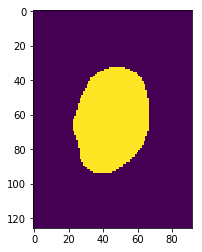

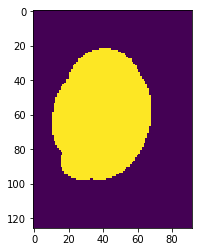

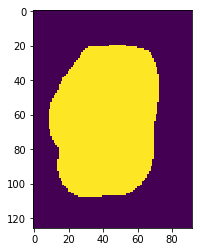

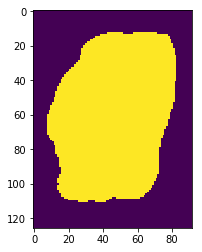

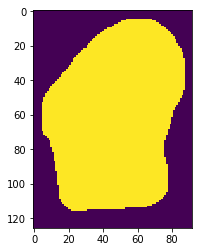

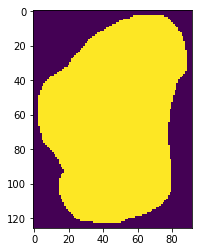

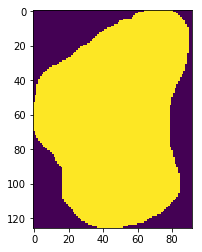

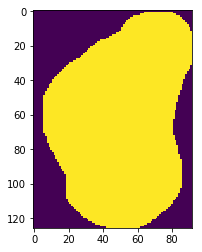

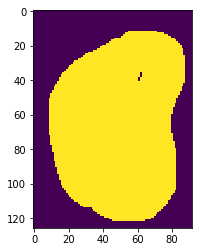

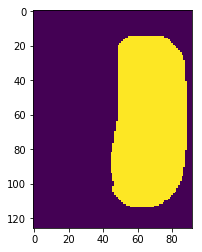

In [11]:
show_slices(bounded)

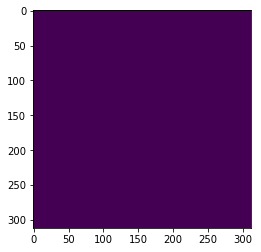

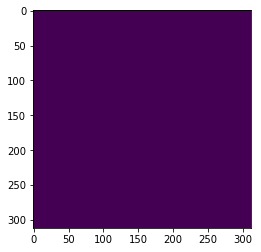

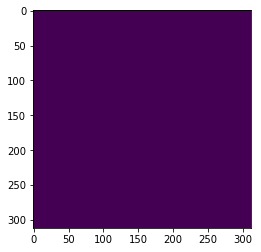

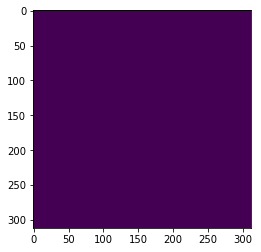

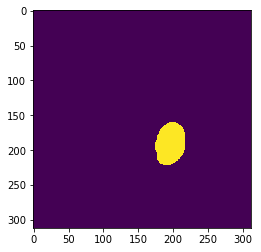

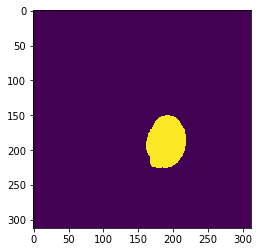

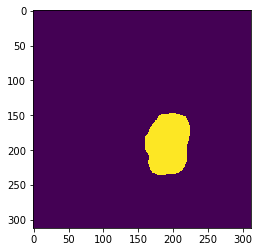

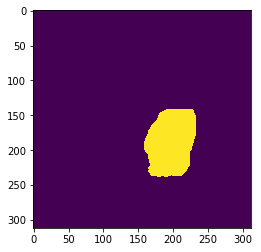

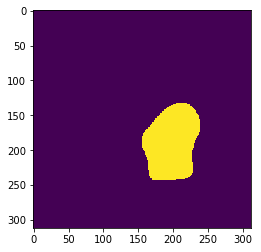

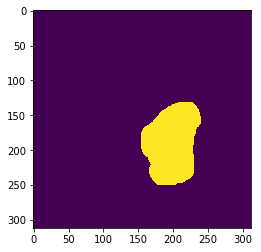

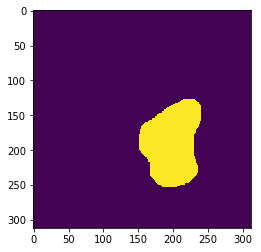

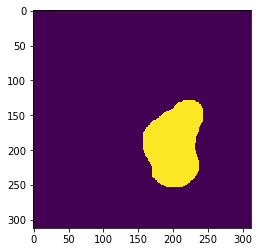

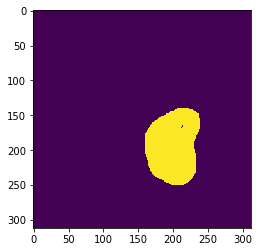

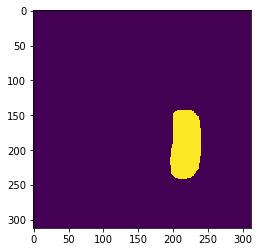

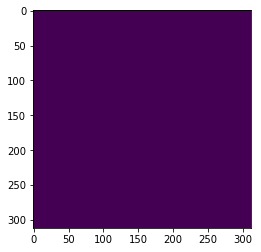

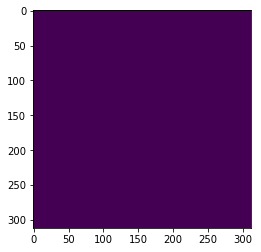

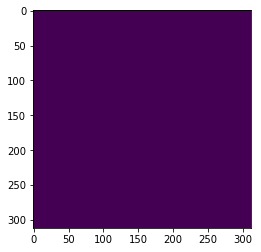

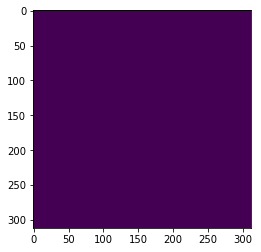

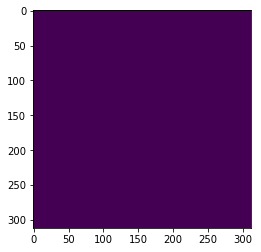

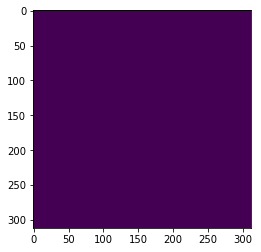

In [12]:
show_slices(vol_mask)